##### imports & constants

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import random as rd
import numpy as np
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.draw import polygon
import cv2
import matplotlib.path as mplpath

raisii_img = '.\\inputs\\P1\\raisi.png'
rohani_img = '.\\inputs\\P1\\rouhani.png'

P_N = np.array([[0,0],
                [0,708],
                [850,0],
                [850,708],
                [360,250],
                [460,250],
                [360,350],
                [480,350],
                [250,400],
                [535,355],
                [435,440],
                [425,500],
                [360,560],
                [500,560],
                [385,485],
                [465,490],
                [430,345],
                [340,330],
                [505,315],[2, 648],[134, 584],[251, 521],[318, 640],[444, 651],[536, 541],[665, 589],[791, 647],
                [231, 412],[176, 364],[153, 289],[279, 85],[391, 57],[524, 107],[579, 271],[569, 304],[551, 337],])

P_M = np.array([[0,0],
                [0,708],
                [850,0],
                [850,708],
                [360,250],
                [460,250],
                [355,350],
                [485,355],
                [250,400],
                [550,400],
                [435,440],
                [425,490],
                [360,560],
                [500,560],
                [370,490],
                [475,490],
                [430,340],
                [340,330],
                [520,315],[22, 700],[171, 629],[272, 560],[344, 637],[451, 630],[544, 567],[708, 605],[830, 659],
                [237, 455],[171, 359],[161, 275],[263, 110],[397, 80],[504, 111],[590, 247],[570, 363],[562, 381],])

##### a.

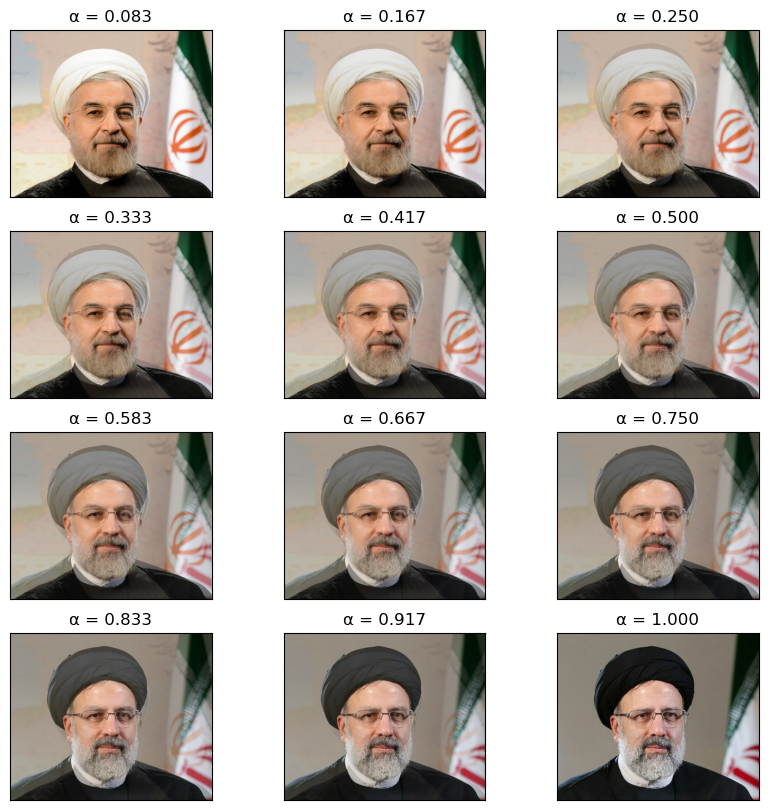

In [4]:
M = np.array(Image.open(rohani_img))
N = np.array(Image.open(raisii_img))
R = []

R += [M]
for i in range(1,11):
    R += [((1-(i/12))*M+(i/12)*N).astype(int)]
R += [N]

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(R[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'α = {(i+1)/12:.3f}')

plt.show()

##### b.

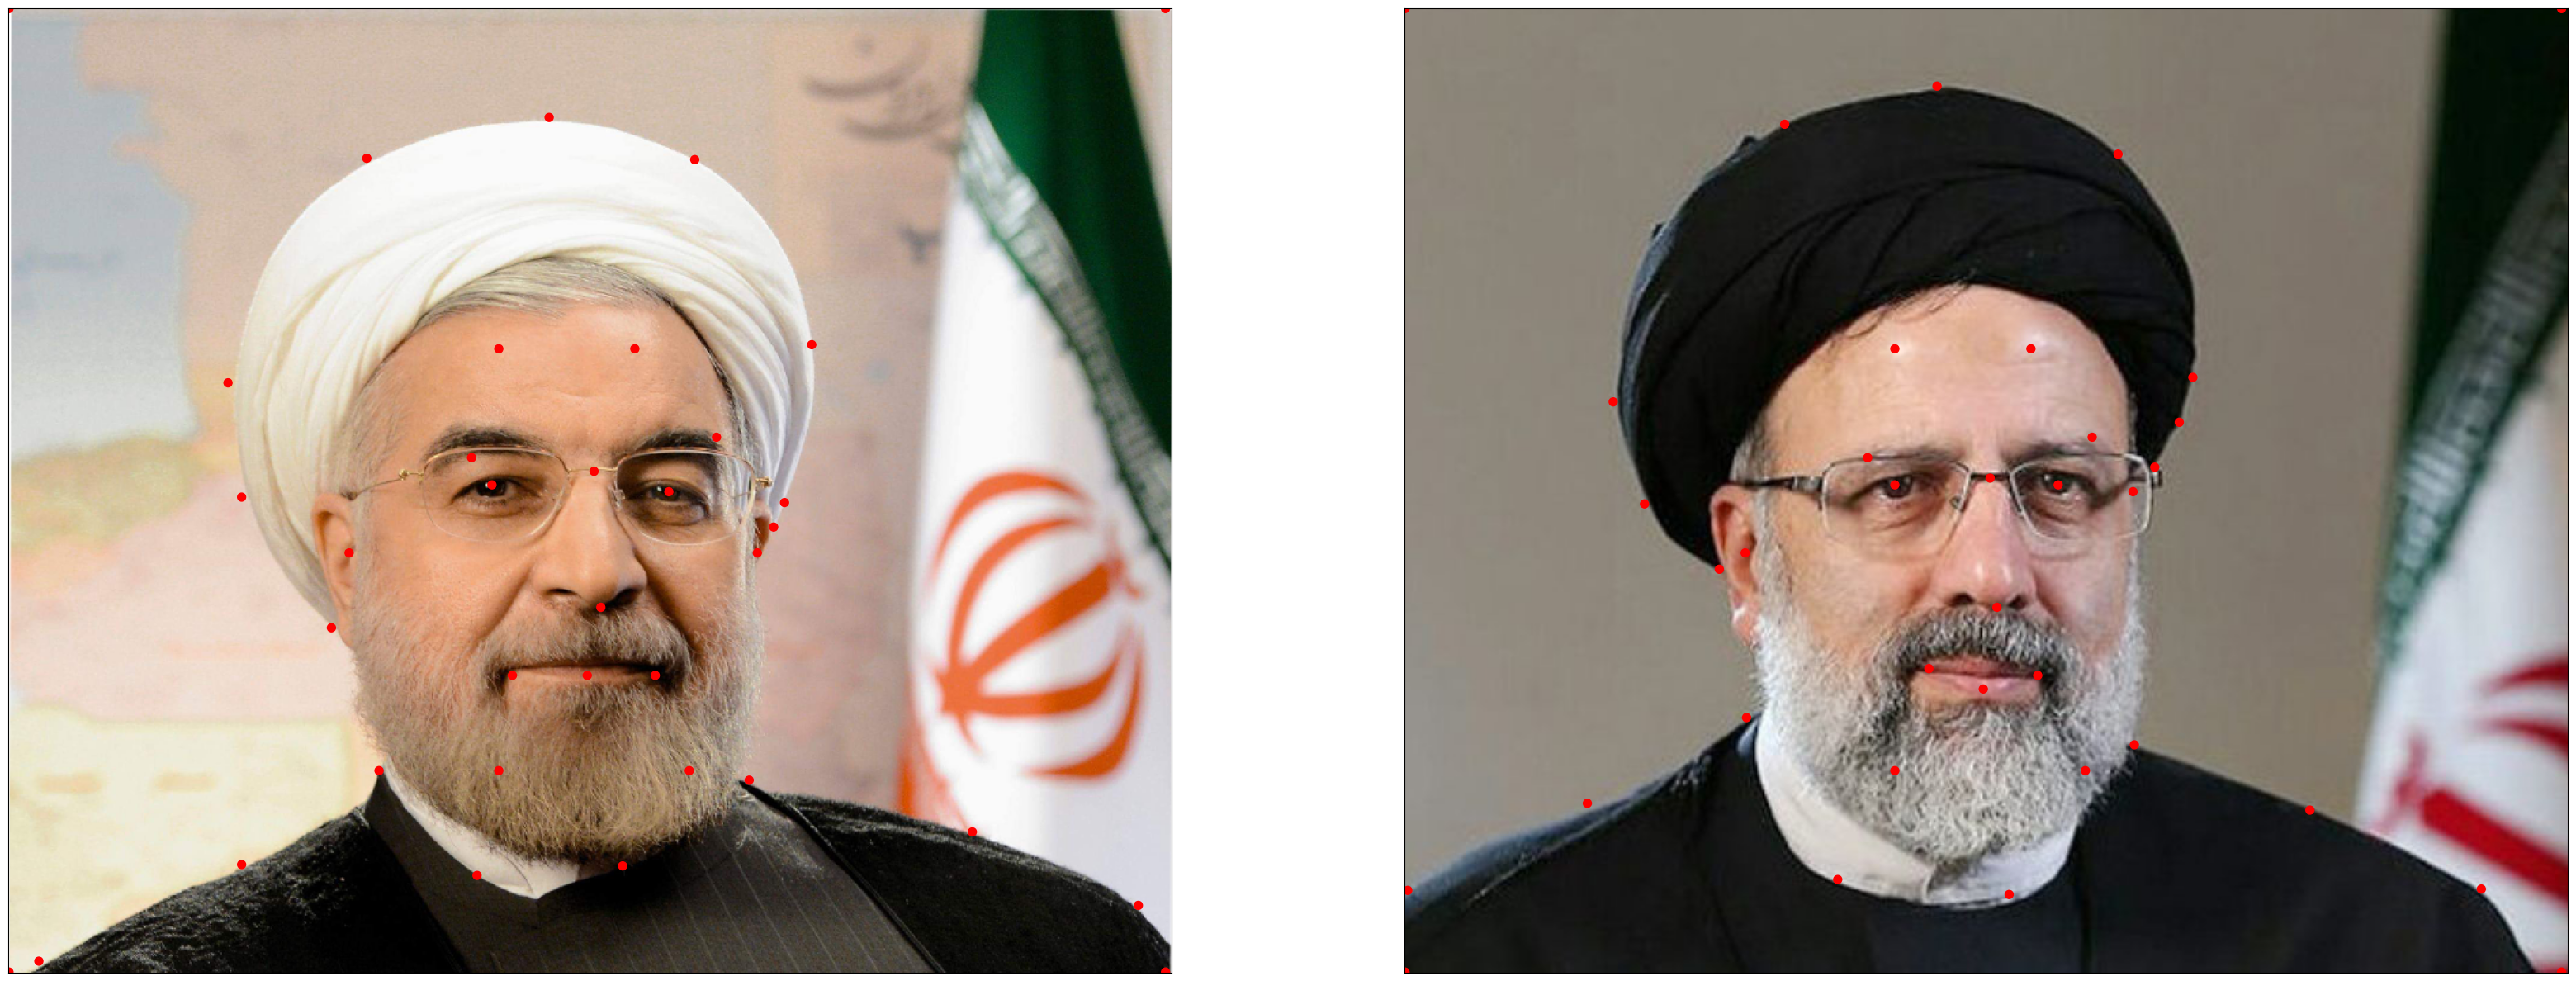

In [5]:
M = np.array(Image.open(rohani_img))
N = np.array(Image.open(raisii_img))
I = [M, N]
P = [P_M, P_N]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
for i, ax in enumerate(axs.flat):
    ax.imshow(I[i])
    ax.set_xticks([])
    ax.set_yticks([])
    for x,y in P[i]:
        ax.add_artist(plt.Circle((x, y), 3, color='red', fill=True))

plt.show()

##### c.

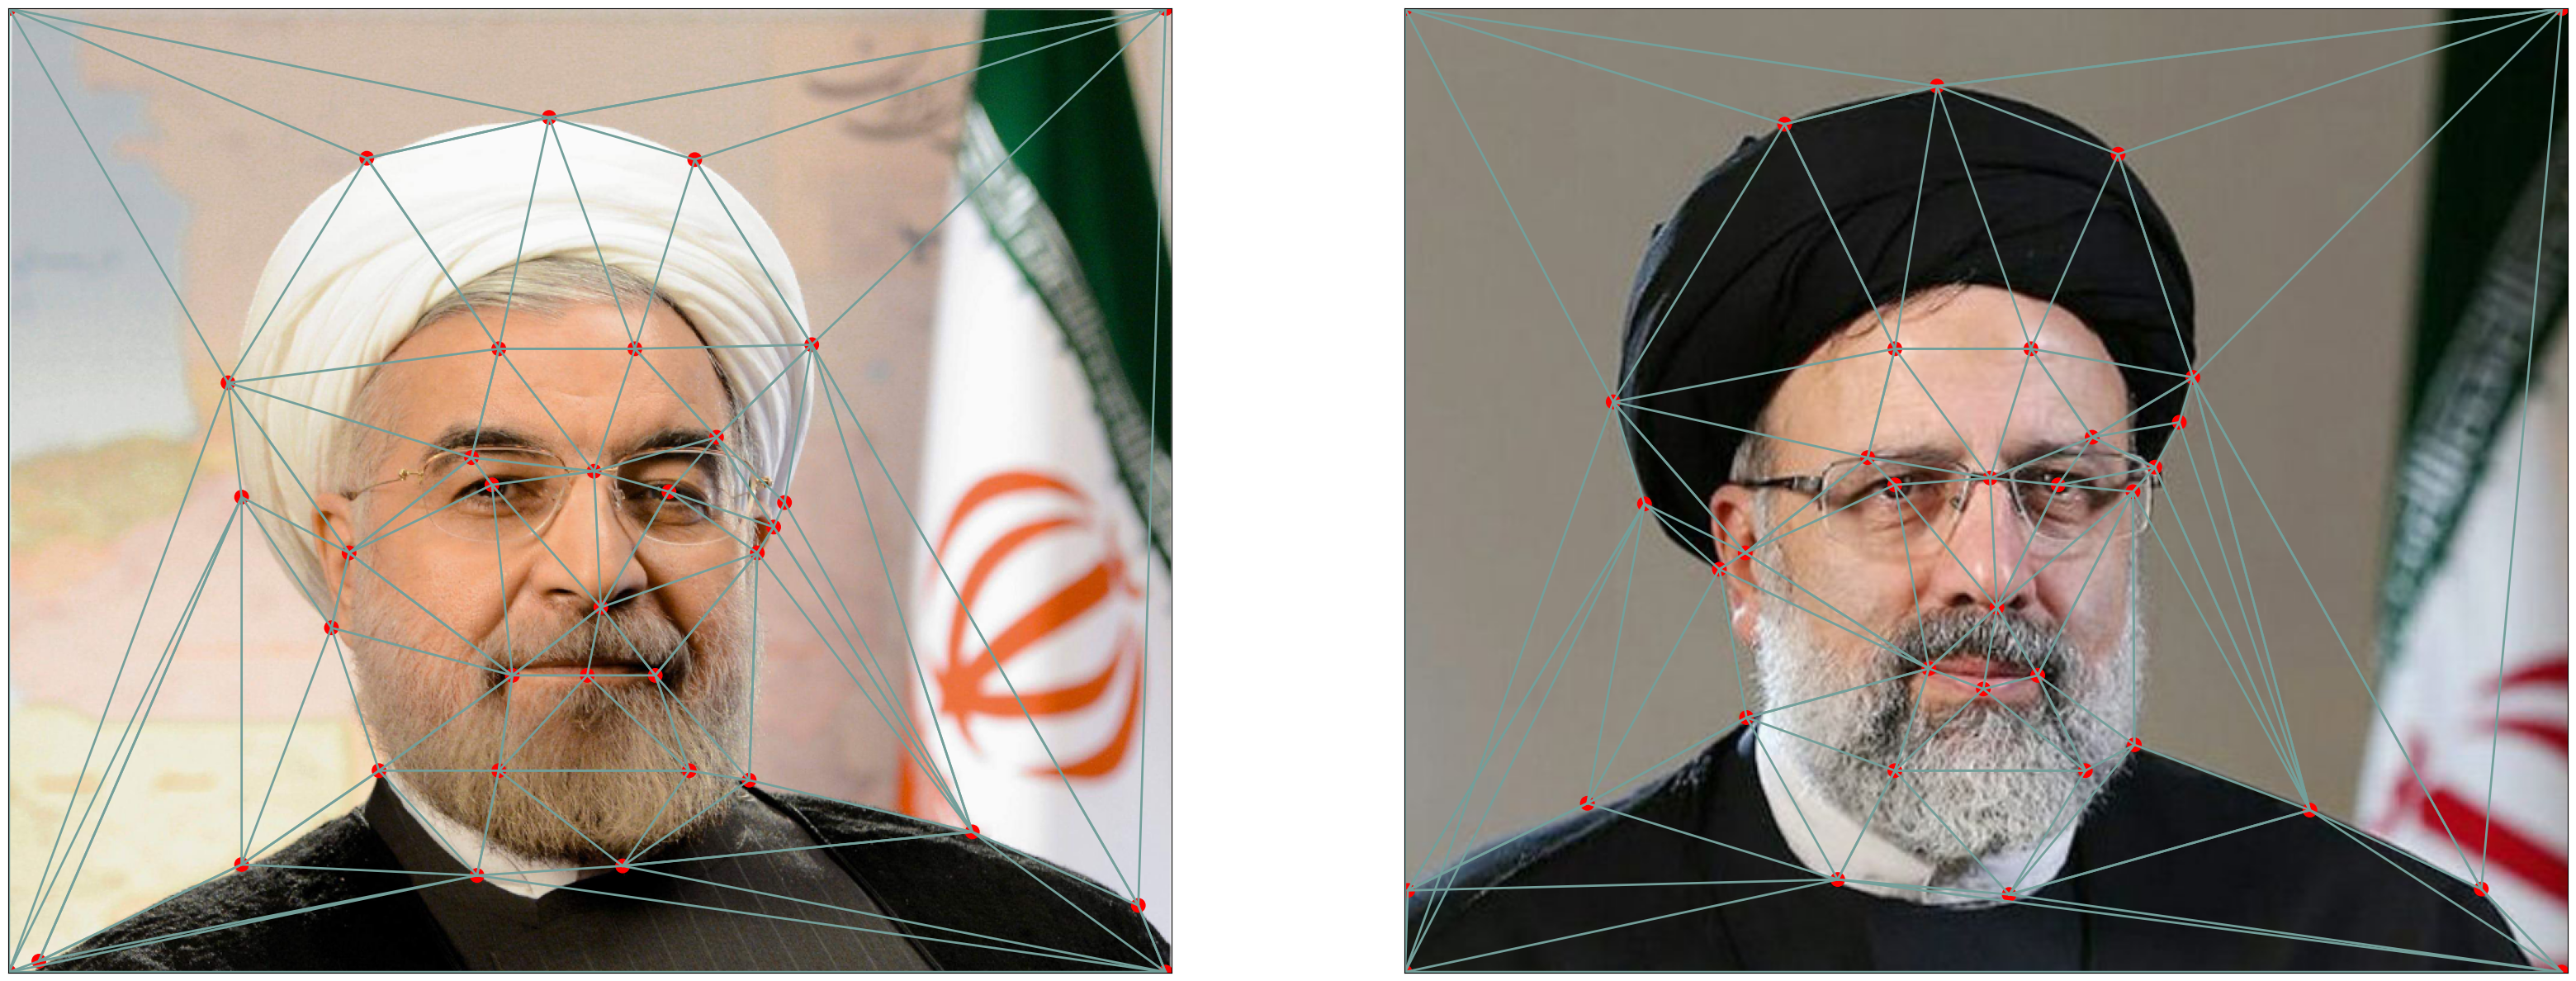

In [6]:
M = np.array(Image.open(rohani_img))
N = np.array(Image.open(raisii_img))
I = [M, N]
P = [P_M, P_N]

P_I = lambda alpha: (1-alpha) * P_M+(alpha)*P_N
T = lambda P: Delaunay(P).simplices

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(40, 40))
IDX = T(P[0])
for i, ax in enumerate(axs.flat):
    ax.imshow(I[i])
    ax.set_xticks([])
    ax.set_yticks([])
    for x,y in P[i]:
        ax.add_artist(plt.Circle((x, y), 5, color='red', fill=True))
    for t in P[i][IDX]:
        ax.plot(t[:, 0], t[:, 1], color=(115/256,160/256,155/256), linewidth=2)
    

plt.show()


##### d.

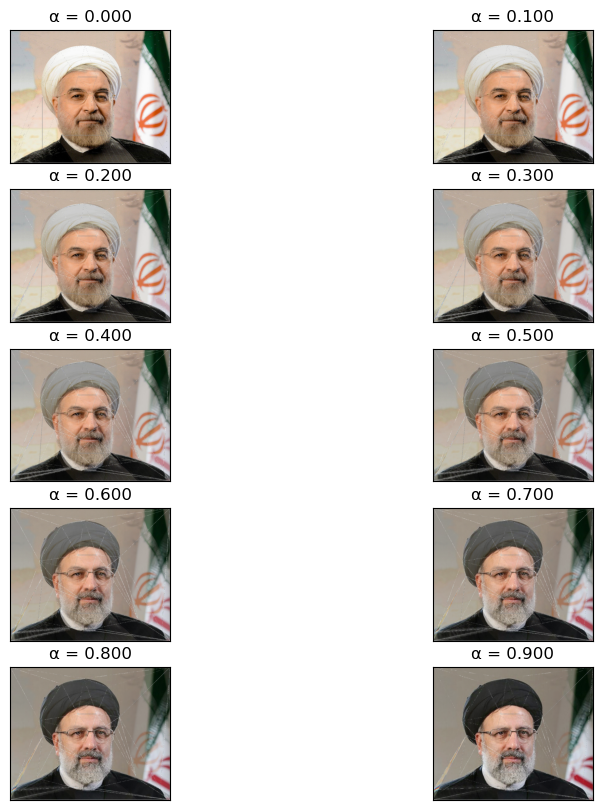

In [6]:
M = np.array(Image.open(rohani_img))
N = np.array(Image.open(raisii_img))
D = [M, N]
P = [P_M, P_N]

f = lambda alpha: ((1-alpha) * P_M+(alpha)*P_N).astype(int)
T = lambda P: Delaunay(P).simplices
clock_wise = lambda t: t[[0,1,2]] if np.cross(t[1] - t[0], t[2] - t[0])>0 else t[[0,2,1]] 

IDX = T(P[0])
T_M = P[0][IDX]
T_N = P[1][IDX]

def warp(src, T_src, T_des):
    r = np.zeros_like(src)
    for t_s, t_d in zip(T_src, T_des):
        # make mask
        x, y = np.meshgrid(np.arange(0, r.shape[1]), np.arange(0, r.shape[0]))
        points = np.vstack((x.flatten(), y.flatten())).T
        path = mplpath.Path(clock_wise(t_s))
        mask = path.contains_points(points,radius=-0.1).reshape((r.shape[0],r.shape[1]))
        # apply transform
        matrix = cv2.getAffineTransform(t_s.astype(np.float32), t_d.astype(np.float32))
        img_afftran = cv2.warpAffine(np.einsum('ijk,ij->ijk', src, mask), matrix, (r.shape[1],r.shape[0]))
        # aggrigate
        r += img_afftran
    return r
        
def morph(alpha):
    P_I = f(alpha)
    T_I = P_I[IDX]
    M_prime = warp(M,T_M,T_I)
    N_prime = warp(N,T_N,T_I)
    return ((1-alpha)*M_prime + alpha*N_prime).astype(int)


R = []
for x in (np.arange(11))*0.1:
    R+=[morph(x)]

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(R[i])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'α = {(i)/10:.3f}')

plt.show()




##### e.

In [7]:
Anim = []
for x in (np.arange(61))*(1/61):
    Anim+=[morph(x)]


In [8]:
from moviepy.editor import ImageSequenceClip

# Create a video clip from the images
clip = ImageSequenceClip(Anim, fps=30)

# Write the clip to a file
clip.write_videofile("C:\\Users\\Koorosh\\Desktop\\DIP_HW4\\inputs\\P1\\output.mp4")

Moviepy - Building video C:\Users\Koorosh\Desktop\DIP_HW4\inputs\P1\output.mp4.
Moviepy - Writing video C:\Users\Koorosh\Desktop\DIP_HW4\inputs\P1\output.mp4



Moviepy - Done !
Moviepy - video ready C:\Users\Koorosh\Desktop\DIP_HW4\inputs\P1\output.mp4


In [8]:
import numpy as np
import matplotlib.path as mplpath

# Define a numpy array with shape (3,2) that specifies a triangle
triangle = np.array([[0, 0], [3, 3], [3, 0]])

clock_wise = lambda t: t[[0,1,2]] if np.cross(t[1] - t[0], t[2] - t[0])>0 else t[[0,2,1]] 

triangle = clock_wise(triangle)
print(triangle)

# Define a grid of points for the image
x, y = np.meshgrid(np.arange(0, 800), np.arange(0, 800))
points = np.vstack((x.flatten(), y.flatten())).T

# Create a matplotlib path for the triangle
path = mplpath.Path(triangle)

# Find the indices of all points inside the triangle
mask = path.contains_points(points,radius=0.1)
# mask = np.logical_or(path.contains_points(points), np.logical_or(path.contains_point(points[0]), np.logical_or(path.contains_point(points[1]), path.contains_point(points[2]))))
indices = np.argwhere(mask.reshape(800,800))

# print(triangle)s
print(indices)
print(mask.reshape(800,800)[0:10,0:10])

[[0 0]
 [3 0]
 [3 3]]
[[0 0]
 [0 1]
 [0 2]
 [0 3]
 [1 1]
 [1 2]
 [1 3]
 [2 2]
 [2 3]
 [3 3]]
[[ True  True  True  True False False False False False False]
 [False  True  True  True False False False False False False]
 [False False  True  True False False False False False False]
 [False False False  True False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False False False False False False False False False]]
